In [1]:
import pandas as pd
from csv import QUOTE_NONE
import numpy as np
import matplotlib.pyplot as plt
from nltk.tokenize import word_tokenize
from collections import Counter
import spacy
import re
import nltk
from nltk.util import bigrams, trigrams
from nltk.corpus import stopwords
nltk.download('stopwords')


[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/niclasstoffregen/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [2]:
# Define the paths to your files
english_file_path = "fr-en/europarl-v7.fr-en.en"
french_file_path = "fr-en/europarl-v7.fr-en.fr"

In [3]:
""" Function to load data into a pandas DataFrame without treating any character as quotes"""

def load_data_to_dataframe(file_path):
    # Read the entire file as a single column DataFrame, ignoring any quoting
    return pd.read_csv(file_path, header=None, names=['text'], encoding='utf-8', sep='\t', quoting=QUOTE_NONE, engine='python')

# Load the data
english_data = load_data_to_dataframe(english_file_path)
french_data = load_data_to_dataframe(french_file_path)

In [4]:
## Take 10% fraction of data randomly sampled
english_data = english_data.sample(frac=0.1, random_state=42)
french_data = french_data.sample(frac=0.1, random_state=42)


In [5]:
# Vocabulary size
"""
comment: 
Instead of nltk use also spicy tokenizer:
import spacy

# Load the English tokenizer from spaCy
nlp_en = spacy.load('en_core_web_sm')

# Example text
text_en = "Apple's looking at buying U.K. startup for $1 billion"

# Process the text
doc_en = nlp_en(text_en)

# Extract tokens
tokens_en = [token.text for token in doc_en]

print(tokens_en)
"""


def build_vocabulary(text_data):
    # Tokenize the text
    tokens = [word_tokenize(text.lower()) for text in text_data]
    # Flatten the list of token lists into a single list of tokens
    all_tokens = [token for sublist in tokens for token in sublist]
    # Create a Counter object to count unique tokens
    vocabulary = Counter(all_tokens)
    return vocabulary


data_en = english_data["text"]
data_fr = french_data["text"]

# Build vocabularies
vocab_en = build_vocabulary(data_en)
vocab_fr = build_vocabulary(data_fr)

# Get the size of each vocabulary
vocab_size_en = len(vocab_en)
vocab_size_fr = len(vocab_fr)

print(f"English Vocabulary Size: {vocab_size_en}")
print(f"French Vocabulary Size: {vocab_size_fr}")

English Vocabulary Size: 48688
French Vocabulary Size: 65955


In [6]:
# TODO average length difference between sentences in source and target language in words and letters
def get_average_length_difference(source,target):
    word_length_dif=[]
    letter_length_dif= []
    for sen_source, sen_target in zip(source["text"],target["text"]):
        #print(sen_source)
        letter_length_dif.append(abs(len(sen_source)- len(sen_target)))
        word_length_dif.append(abs(len(sen_source.split())-len(sen_target.split())))
    print(np.mean(letter_length_dif))
    print(np.mean(word_length_dif))
    #print(len(sen_source.split()))

get_average_length_difference(english_data,french_data)


103.1205313274707
16.44967303308576


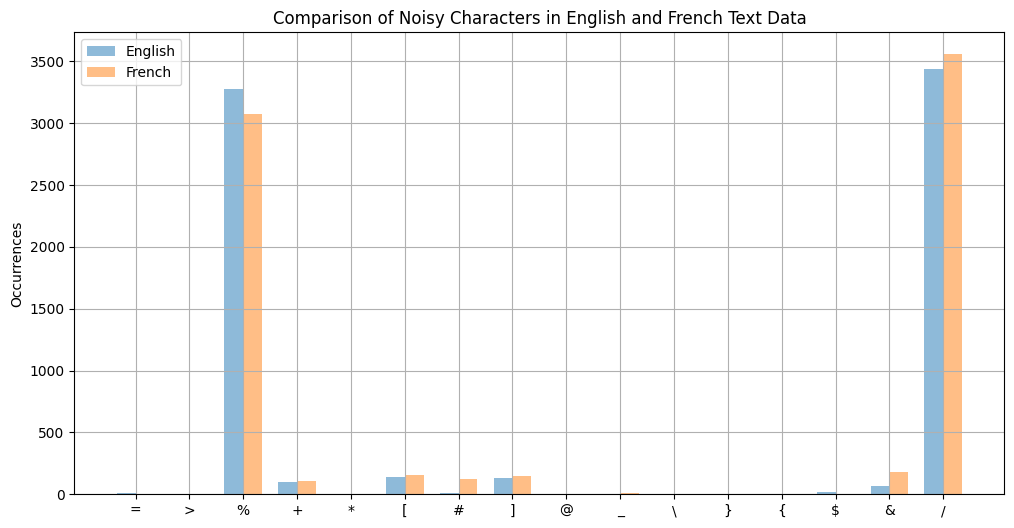

In [8]:


def overlay_noisy_character_counts(data_en, data_fr):
    # Define the characters to remove
    noisy_characters = re.escape('@#$%^&*~<>|\\{}[]+=_/')
    
    # Regex to match any noisy character
    regex_pattern = f'[{noisy_characters}]'
    
    # Function to count characters in a dataframe
    def count_characters(data):
        character_counts = Counter()
        for text in data['text']:
            found_chars = re.findall(regex_pattern, text)
            character_counts.update(found_chars)
        return character_counts

    # Count characters for both datasets
    en_counts = count_characters(data_en)
    fr_counts = count_characters(data_fr)

    # Plotting the occurrences for both English and French data in one overlaid histogram
    plt.figure(figsize=(12, 6))
    labels, en_values = zip(*en_counts.items())  # Unpack keys and values for English
    _, fr_values = zip(*fr_counts.items())      # Unpack values for French
    
    # Ensure both languages have entries for each label
    labels = list(set(labels + tuple(fr_counts.keys())))
    en_values = [en_counts.get(label, 0) for label in labels]
    fr_values = [fr_counts.get(label, 0) for label in labels]

    # Plot
    indices = np.arange(len(labels))  # the x locations for the groups
    width = 0.35                     # the width of the bars
    
    plt.bar(indices - width/2, en_values, width, label='English', alpha=0.5)
    plt.bar(indices + width/2, fr_values, width, label='French', alpha=0.5)

    plt.ylabel('Occurrences')
    plt.title('Comparison of Noisy Characters in English and French Text Data')
    plt.xticks(indices, labels)
    plt.legend()
    plt.grid(True)

    # save to figures
    plt.savefig('reports/figures/noisy_characters.png')
    plt.show()

    return en_counts, fr_counts

en_noisy_character_counts, fr_noisy_character_counts = overlay_noisy_character_counts(english_data, french_data)


English average word count: 27.77066246528626
French average word count: 29.588500541203818
English average sentence length in letters: 149.2377635626642
French average sentence length in letters: 166.2798048673427


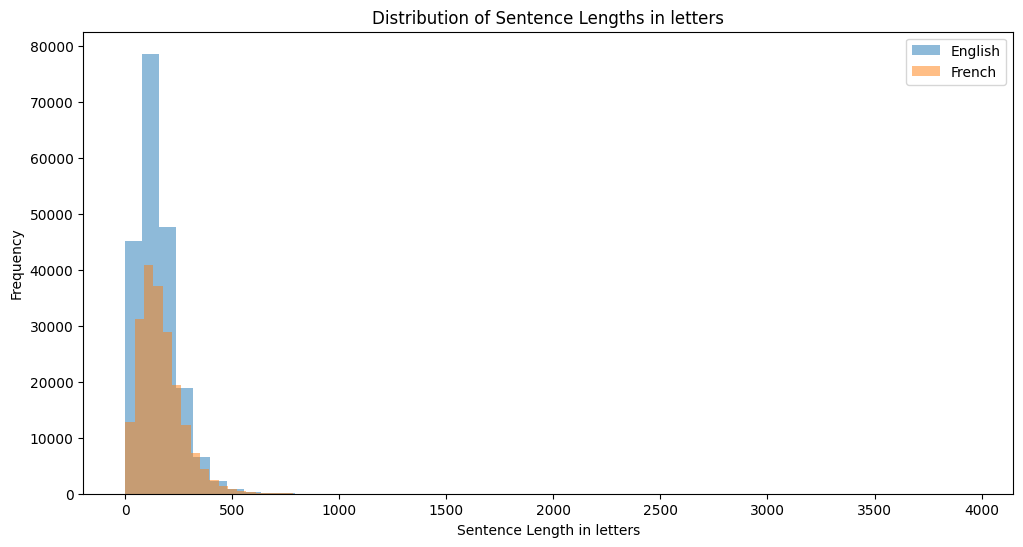

Most common words in English:
[('the', 384824), (',', 267179), ('.', 197870), ('of', 181909), ('to', 170414), ('and', 145152), ('in', 119340), ('that', 91867), ('a', 85758), ('is', 84889)]
Most common words in French:
[('de', 291717), (',', 285271), ('.', 199346), ('la', 188500), ('et', 134892), ('le', 126366), ('les', 114711), ('à', 112473), ('des', 105994), ('que', 88525)]


In [9]:


# Adding word count and sentence length columns
english_data['word_count'] = english_data['text'].apply(lambda x: len(word_tokenize(x)))
french_data['word_count'] = french_data['text'].apply(lambda x: len(word_tokenize(x)))

english_data['sentence_length_in_letters'] = english_data['text'].apply(len)
french_data['sentence_length_in_letters'] = french_data['text'].apply(len)

# Basic statistics
print("English average word count:", english_data['word_count'].mean())
print("French average word count:", french_data['word_count'].mean())
print("English average sentence length in letters:", english_data['sentence_length_in_letters'].mean())
print("French average sentence length in letters:", french_data['sentence_length_in_letters'].mean())

# Histogram of sentence lengths
plt.figure(figsize=(12, 6))
plt.hist(english_data['sentence_length_in_letters'], bins=50, alpha=0.5, label='English')
plt.hist(french_data['sentence_length_in_letters'], bins=50, alpha=0.5, label='French')
plt.title('Distribution of Sentence Lengths in letters')
plt.xlabel('Sentence Length in letters')
plt.ylabel('Frequency')
plt.legend()
plt.savefig('reports/figures/sentence_length.png')
plt.show()

# Most common words
top_n = 10
english_words = Counter(word.lower() for sentence in english_data['text'] for word in word_tokenize(sentence))
french_words = Counter(word.lower() for sentence in french_data['text'] for word in word_tokenize(sentence))

print("Most common words in English:")
print(english_words.most_common(top_n))

print("Most common words in French:")
print(french_words.most_common(top_n))

In [10]:
# TODO: takes too long when uncommenting the paragraph below

# Load spaCy models
nlp_en = spacy.load('en_core_web_sm')
nlp_fr = spacy.load('fr_core_news_sm')

# Stopwords setup
stopwords_en = set(stopwords.words('english'))
stopwords_fr = set(stopwords.words('french'))

# Helper function to perform advanced analyses
def analyze_text(data, language):
    
    # Create a copy of the DataFrame to avoid SettingWithCopyWarning
    data = data.copy()
    # Tokenization and removing punctuation
    data['tokens'] = data['text'].apply(lambda x: [token.text.lower() for token in nlp_en(x) if token.is_alpha])
    data['num_tokens'] = data['tokens'].apply(len)

    # Stopword analysis
    data['stopword_count'] = data['tokens'].apply(lambda x: sum(token in (stopwords_en if language == 'English' else stopwords_fr) for token in x))
    data['stopword_ratio'] = data['stopword_count'] / data['num_tokens']

    # Lexical diversity
    data['lexical_diversity'] = data['tokens'].apply(lambda x: len(set(x)) / len(x) if x else 0)

    # N-Gram analysis
    data['bigrams'] = data['tokens'].apply(lambda x: list(bigrams(x)))
    data['trigrams'] = data['tokens'].apply(lambda x: list(trigrams(x)))

    # POS tagging
    data['pos_tags'] = data['text'].apply(lambda x: [token.pos_ for token in nlp_en(x) if token.is_alpha])

    # Sentence complexity (count of clauses per sentence)
    data['sentence_complexity'] = data['text'].apply(lambda x: sum(1 for token in nlp_en(x) if token.dep_ == 'conj'))

    return data

"""english_data = analyze_text(english_data, 'English')
french_data = analyze_text(french_data, 'French')

# Example output of analysis
print("English sample analysis:")
print(english_data[['lexical_diversity', 'stopword_ratio', 'sentence_complexity']].head())
print("French sample analysis:")
print(french_data[['lexical_diversity', 'stopword_ratio', 'sentence_complexity']].head())

# Visualization of sentence complexity
plt.figure(figsize=(10, 6))
plt.hist(english_data['sentence_complexity'], bins=30, alpha=0.5, label='English', color='blue')
plt.hist(french_data['sentence_complexity'], bins=30, alpha=0.5, label='French', color='red')
plt.title('Distribution of Sentence Complexity')
plt.xlabel('Number of Clauses per Sentence')
plt.ylabel('Frequency')
plt.legend()
plt.savefig('reports/figures/sentence_complexity.png')
plt.show()"""

'english_data = analyze_text(english_data, \'English\')\nfrench_data = analyze_text(french_data, \'French\')\n\n# Example output of analysis\nprint("English sample analysis:")\nprint(english_data[[\'lexical_diversity\', \'stopword_ratio\', \'sentence_complexity\']].head())\nprint("French sample analysis:")\nprint(french_data[[\'lexical_diversity\', \'stopword_ratio\', \'sentence_complexity\']].head())\n\n# Visualization of sentence complexity\nplt.figure(figsize=(10, 6))\nplt.hist(english_data[\'sentence_complexity\'], bins=30, alpha=0.5, label=\'English\', color=\'blue\')\nplt.hist(french_data[\'sentence_complexity\'], bins=30, alpha=0.5, label=\'French\', color=\'red\')\nplt.title(\'Distribution of Sentence Complexity\')\nplt.xlabel(\'Number of Clauses per Sentence\')\nplt.ylabel(\'Frequency\')\nplt.legend()\nplt.savefig(\'reports/figures/sentence_complexity.png\')\nplt.show()'